In [2]:
import yfinance as yf

stock_ls = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

data = yf.download(stock_ls, start="2024-01-01", end="2024-10-01")[['Adj Close']]



[*********************100%***********************]  5 of 5 completed


In [8]:
import vnstock3 as vs3
import pandas as pd

# Các mã cổ phiếu cần lấy dữ liệu
tickers = ['VIC', 'VNM', 'HPG', 'FPT']
start_date = '2023-01-01'
end_date = '2024-01-01'

# Tạo dataframe lưu dữ liệu lịch sử giá đóng cửa của các cổ phiếu
data = pd.DataFrame()

for ticker in tickers:
    stock_data = vs3.stock_historical_data(ticker, start_date, end_date)
    stock_data['ticker'] = ticker
    stock_data = stock_data[['date', 'close', 'ticker']]
    stock_data = stock_data.rename(columns={'close': f'{ticker}_Close'})
    
    if data.empty:
        data = stock_data
    else:
        data = pd.merge(data, stock_data, on='date')

# Hiển thị dữ liệu đã thu thập
print(data.head())

AttributeError: module 'vnstock3' has no attribute 'stock_historical_data'

In [3]:
import numpy as np


# Tính lợi suất hằng ngày
returns = data.pct_change().dropna()

# Tính lợi suất trung bình hàng năm
mean_returns = returns.mean() * 252

# Tính ma trận hiệp phương sai
cov_matrix = returns.cov() * 252
cov_matrix

Price            Adj Close                                        
Ticker                AAPL      AMZN     GOOGL      MSFT      TSLA
Price     Ticker                                                  
Adj Close AAPL    0.056901  0.021644  0.025839  0.020763  0.055799
          AMZN    0.021644  0.076702  0.040605  0.036515  0.050414
          GOOGL   0.025839  0.040605  0.077008  0.033408  0.032523
          MSFT    0.020763  0.036515  0.033408  0.038034  0.034966
          TSLA    0.055799  0.050414  0.032523  0.034966  0.333577

In [11]:
from scipy.optimize import minimize
# Mô hình Markowitz

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [12]:
# Hiển thị kết quả

risk_free_rate = 0.01  # Giả sử lãi suất phi rủi ro là 1%
optimal_result = optimize_portfolio(mean_returns, cov_matrix, risk_free_rate)

# Hiển thị kết quả tối ưu
optimal_weights = optimal_result.x
std, ret = portfolio_annualized_performance(optimal_weights, mean_returns, cov_matrix)

print(f"Lợi suất kỳ vọng: {ret:.2f}, Độ lệch chuẩn: {std:.2f}")
print("Tỷ trọng phân bổ tài sản tối ưu:", optimal_weights)

Lợi suất kỳ vọng: 0.33, Độ lệch chuẩn: 0.20
Tỷ trọng phân bổ tài sản tối ưu: [0.56155932 0.30334247 0.088601   0.04649721 0.        ]


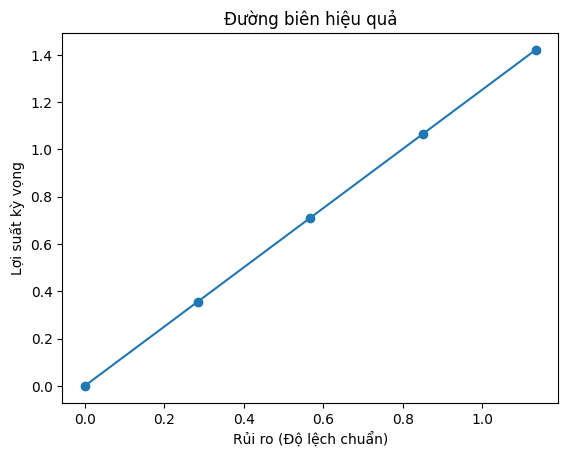

In [13]:
# Biểu đồ
import matplotlib.pyplot as plt


def plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, len(mean_returns)))
    
    for i, weight in enumerate(np.linspace(0, 1, len(mean_returns))):
        weight_comb = np.ones(len(mean_returns)) * weight
        std, ret = portfolio_annualized_performance(weight_comb, mean_returns, cov_matrix)
        results[0,i] = std
        results[1,i] = ret
    
    plt.plot(results[0,:], results[1,:], marker='o')
    plt.xlabel('Rủi ro (Độ lệch chuẩn)')
    plt.ylabel('Lợi suất kỳ vọng')
    plt.title('Đường biên hiệu quả')
    plt.show()

plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate)

In [7]:
from vnstock import stock_historical_data
import pandas as pd

# Lấy dữ liệu lịch sử giá cổ phiếu VNM từ 2020-01-01 đến 2021-01-01
data = stock_historical_data('VNM', '2020-01-01', '2021-01-01')

# Kiểm tra cấu trúc của DataFrame
print(data.head())

# Giả sử cột ngày có tên khác, ví dụ: 'Date'
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
else:
    raise KeyError("The 'Date' column is missing from the data.")

# Tính lợi suất hằng ngày
returns = data.pct_change().dropna()

# Tính ma trận hiệp phương sai
cov_matrix = returns.cov()
print(cov_matrix)

         time   open   high    low  close  volume ticker
0  2020-01-02  78060  78850  77720  78660  352700    VNM
1  2020-01-03  78850  79380  78850  78920  625390    VNM
2  2020-01-06  78720  78850  77920  78320  495910    VNM
3  2020-01-07  78380  79240  78380  79050  459520    VNM
4  2020-01-08  79050  79240  78380  79240  837710    VNM


KeyError: "The 'Date' column is missing from the data."

In [11]:
import vnstock
import pandas as pd

def lay_gia_dong_cua(ma_chung_khoan: str , start_date: str, end_date: str):
    data = vnstock.stock_historical_data(ma_chung_khoan, start_date,end_date)
    
    gia_dong_cua = data[['time', 'close','ticker']]
    return gia_dong_cua
    
ma_chung_khoan = 'VNM'
start_date = '2020-01-01'
end_date = '2021-01-01'
gia_dong_cua_vnm = lay_gia_dong_cua(ma_chung_khoan, start_date, end_date)
print(gia_dong_cua_vnm)

           time  close ticker
0    2020-01-02  78660    VNM
1    2020-01-03  78920    VNM
2    2020-01-06  78320    VNM
3    2020-01-07  79050    VNM
4    2020-01-08  79240    VNM
..          ...    ...    ...
247  2020-12-25  89760    VNM
248  2020-12-28  89510    VNM
249  2020-12-29  89930    VNM
250  2020-12-30  89580    VNM
251  2020-12-31  89580    VNM

[252 rows x 3 columns]


In [12]:
import vnstock
import pandas as pd

# Hàm lấy giá đóng cửa cho nhiều mã chứng khoán
def lay_gia_dong_cua_nhieu_ma(danh_sach_ma: list, start_date: str, end_date: str):
    # Danh sách để lưu trữ dữ liệu từ các mã chứng khoán
    data_frames = []
    
    for ma_chung_khoan in danh_sach_ma:
        # Lấy dữ liệu cho từng mã chứng khoán
        data = vnstock.stock_historical_data(ma_chung_khoan, start_date, end_date)
        
        # Trích xuất cột thời gian ('time'), giá đóng cửa ('close') và mã chứng khoán ('ticker')
        gia_dong_cua = data[['time', 'close', 'ticker']]
        
        # Thêm dữ liệu vào danh sách
        data_frames.append(gia_dong_cua)
    
    # Kết hợp tất cả các DataFrame lại thành một DataFrame lớn
    all_data = pd.concat(data_frames, ignore_index=True)
    
    return all_data

# Thí dụ: lấy giá đóng cửa của nhiều mã chứng khoán từ ngày 2020-01-01 đến 2021-01-01
danh_sach_ma = ['VNM', 'HPG', 'VCB']  # Danh sách các mã chứng khoán
start_date = '2020-01-01'
end_date = '2021-01-01'

# Lấy toàn bộ dữ liệu giá đóng cửa cho nhiều mã
gia_dong_cua_nhieu_ma = lay_gia_dong_cua_nhieu_ma(danh_sach_ma, start_date, end_date)

# Hiển thị dữ liệu
print(gia_dong_cua_nhieu_ma)


           time  close ticker
0    2020-01-02  78660    VNM
1    2020-01-03  78920    VNM
2    2020-01-06  78320    VNM
3    2020-01-07  79050    VNM
4    2020-01-08  79240    VNM
..          ...    ...    ...
751  2020-12-25  64010    VCB
752  2020-12-28  64269    VCB
753  2020-12-29  65060    VCB
754  2020-12-30  64200    VCB
755  2020-12-31  64200    VCB

[756 rows x 3 columns]


In [15]:
import vnstock
import pandas as pd

ticker_mapping = ['VIC', 'VNM', 'MSN', 'HPG', 'BID', 'VPB', 'VCB']

def get_data_stock(ticker: str, start_date: str, end_date: str):
    data = vnstock.stock_historical_data(ticker, start_date, end_date)
    data_dict = data[['time','close','ticker']]
    return data_dict

for ticker in ticker_mapping:
    data = get_data_stock(ticker, '2020-01-01', '2021-01-01')
    print(data)


           time   close ticker
0    2020-01-02  102210    VIC
1    2020-01-03  102477    VIC
2    2020-01-06  101766    VIC
3    2020-01-07  101943    VIC
4    2020-01-08  101588    VIC
..          ...     ...    ...
247  2020-12-25   94122    VIC
248  2020-12-28   94122    VIC
249  2020-12-29   94655    VIC
250  2020-12-30   96433    VIC
251  2020-12-31   96166    VIC

[252 rows x 3 columns]
           time  close ticker
0    2020-01-02  78660    VNM
1    2020-01-03  78920    VNM
2    2020-01-06  78320    VNM
3    2020-01-07  79050    VNM
4    2020-01-08  79240    VNM
..          ...    ...    ...
247  2020-12-25  89760    VNM
248  2020-12-28  89510    VNM
249  2020-12-29  89930    VNM
250  2020-12-30  89580    VNM
251  2020-12-31  89580    VNM

[252 rows x 3 columns]
           time  close ticker
0    2020-01-02  46160    MSN
1    2020-01-03  46570    MSN
2    2020-01-06  45830    MSN
3    2020-01-07  46000    MSN
4    2020-01-08  45350    MSN
..          ...    ...    ...
247  2020-